# Face Detection and Emotion Recognition

The goal of your project is to create a robust Image classifier, that given an image will find all of the faces within the image and then recognize the emotion of the person. You will need to utilize deep learning models, as well the Computer Vision library OpenCV, which will help you in your task.

The 7 emotions that you classifier will need to choose from are:
* Contempt
* Happiness
* Sadness
* Fear
* Disgust
* Anger
* Surprise

as well as the Neutral class.

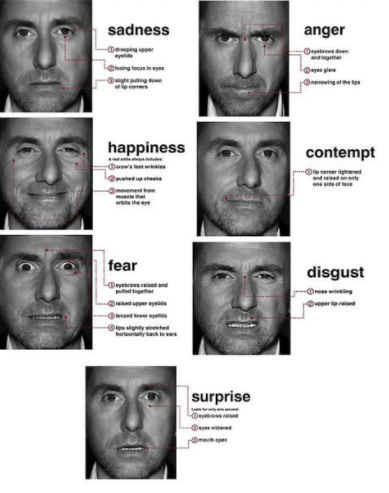


    

# Working Plan



1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection*
    * Dataset Preparation

2. Phase 2 : Training
    * Research the library OpenCV for face detection
    * Research about neural networks and how they can be used for Emotion Recognition
    * Compose and train neural network architectures
    * Generate new data if needed
    * Fine tuning of your model

3. Phase 3 : Deployment
    * Perform benchmark (precision/recall)
    * Explain Model*
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM

## 0. Read data, visualize, basic statistics, understand it

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.utils import np_utils
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()
import shap
from tensorflow import keras
from keras import layers,models
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# pip install tensorflow-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Fer2013/fer2013.csv"
df = pd.read_csv(path)

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


We give the emotion column more intuitive labels

In [ ]:
emotion_label = np.array(['anger','disgust','fear', 'happiness', 'sadness', 'surprise','neutral'])

In [ ]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


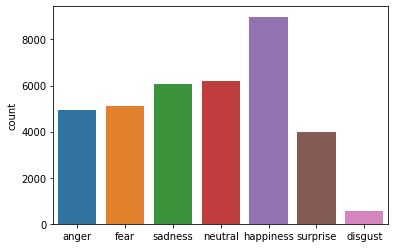

In [ ]:
emotion_names=emotion_label[df['emotion']]
sns.countplot(emotion_names)

We can see that the 'disgust' class is least represented. We can try to change that later with data augmentation.

We display the first 7 pictures from the 7 target categories

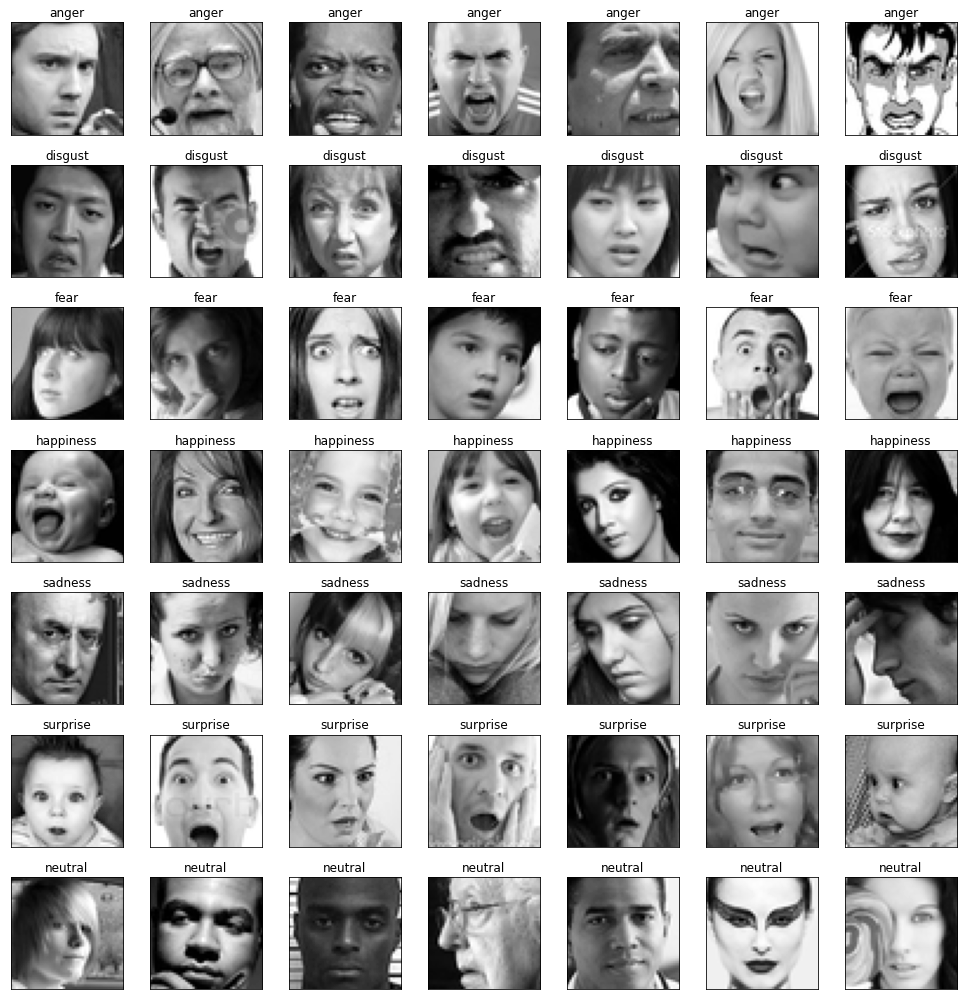

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

We split the data into train, test and validation data

In [ ]:
df_train=df.loc[df['Usage']=='Training']
df_test=df.loc[df['Usage']=='PublicTest']
df_validation=df.loc[df['Usage']=='PrivateTest']

## Defining functions

In [ ]:
def data_reshape(df,col,h,w):
  '''
  Reshapes data in appropriate format for image show
  '''
  data=df[col].apply(lambda x: np.array(x.split(' ')).reshape(h, w).astype('float32'))

  return data

In [ ]:
def get_transformed_data(df,col,h,w,channel):
  '''
  Transforms the data into appropriate form for neural networks training
  '''
  df_transformed = np.array(list(map(str.split, df[col])), np.float32).reshape(df.shape[0],48,48,channel)
  df_scaled=df_transformed.astype('float32')/255.0


  return df_scaled


In [ ]:
def to_3channel(imgs):
  imgs_3ch=[]
  for img in imgs:
    # x1=img.shape[0]
    # x2=img.shape[1]
    # image=tf.reshape(tf.broadcast_to(img, (x1, x2, 3)),  (x1, x2, 3))
    image = cv2.merge((img,img,img))
    imgs_3ch.append(image)
  imgs_3ch=np.array(imgs_3ch)

  return imgs_3ch

In [ ]:
def print_confusion_matrix(model_list, labels):
    
    matrices=[]
    for model in model_list:
        y_pred = model.predict(X_test_scaled)
        y_pred_cl = np.argmax(y_pred, axis = 1)
        cf_matrix = confusion_matrix(y_test, y_pred_cl)
        matrices.append(cf_matrix)
    
    plt.figure(figsize=(20,8))
    
    for idx,matrix in enumerate(matrices):
        ax = plt.subplot(120 + 1 + idx)

        counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
        percents = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

        labs = [f"{l1}\n{l2}" for l1,l2 in zip (counts,percents)]
        labs = np.asarray(labs).reshape(len(labels),len(labels))

        # sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='Blues') 
        sns.heatmap(matrix, annot=labs, fmt='', ax=ax, cmap='Blues') 
        
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    

In [ ]:
def get_metrics(model):
    
    y_pred = model.predict(X_test_scaled)
    y_pred_cl = np.argmax(y_pred, axis = 1)
    acc_= accuracy_score(y_pred_cl,y_test)
    recall_= recall_score(y_pred_cl,y_test,average='macro')
    precision_= precision_score(y_pred_cl,y_test,average='macro')
    f1_= f1_score(y_pred_cl,y_test,average='macro')
    scores = [acc_,recall_,precision_,f1_]
    
    return scores

## Data augmentation

In [ ]:
df_disgust=df.loc[df['emotion']==1]
df_disgust_images=data_reshape(df_disgust,'pixels',48,48)
df_d_scaled=get_transformed_data(df_disgust,'pixels',48,48,1)
df_3d_scaled=to_3channel(df_d_scaled)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 30, #0-30
    zoom_range = 0.4,
    horizontal_flip = True,
    rescale=1./255,
    brightness_range=[0.6,1.5],
    fill_mode = 'nearest')

train_generator = train_datagen.flow(df_3d_scaled,df_disgust['emotion'],batch_size=32,shuffle=True)

In [ ]:
list_gen = []
for e in range(10):
  batches = 0
  for xbatch,ybatch in train_generator:
    list_gen.append(xbatch)
    batches += 1
    if batches >= len(df_3d_scaled) / 32:
            break


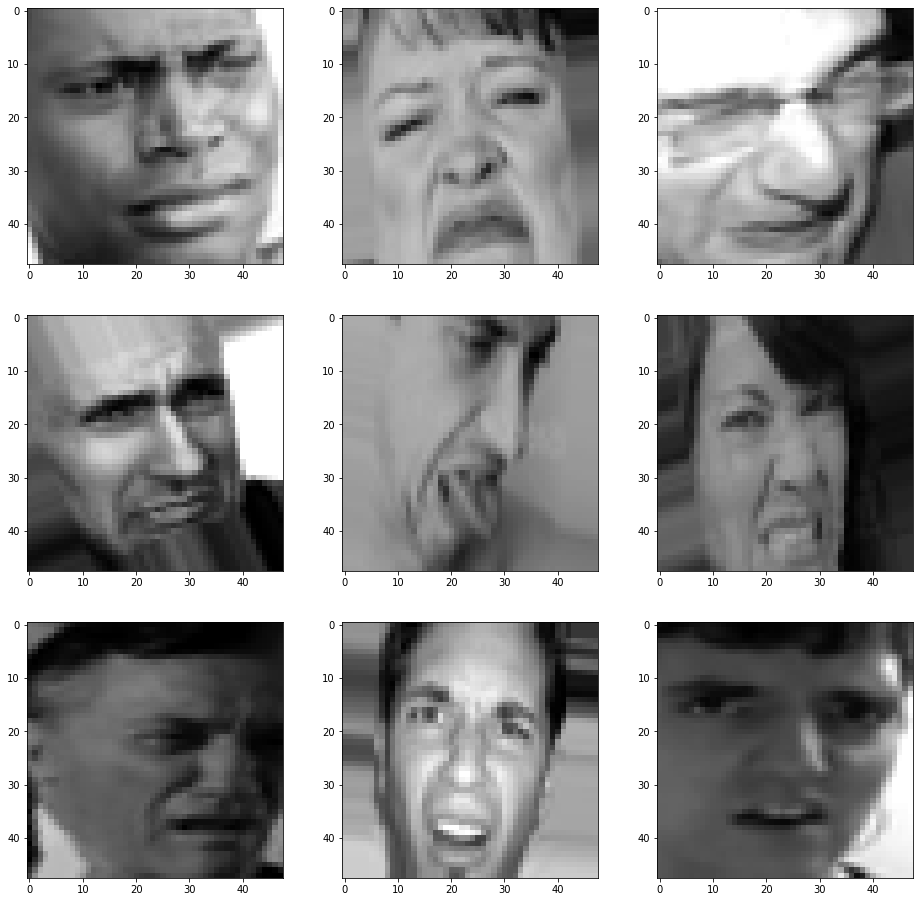

In [ ]:
plt.figure(figsize=(16, 16))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0, 9):
#         print(np.amax(X_batch[i]))
#         print(np.amin(X_batch[i]))
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break


## Data transforming

In [ ]:
train_images=data_reshape(df_train,'pixels',48,48)
test_images=data_reshape(df_test,'pixels',48,48)
val_images=data_reshape(df_validation,'pixels',48,48)

In [ ]:
X_train_scaled=get_transformed_data(df_train,'pixels',48,48,1)
X_test_scaled=get_transformed_data(df_test,'pixels',48,48,1)
X_val_scaled=get_transformed_data(df_validation,'pixels',48,48,1)


In [ ]:
X_train_3c=to_3channel(X_train_scaled)
X_test_3c=to_3channel(X_test_scaled)
X_val_3c=to_3channel(X_val_scaled)


In [ ]:
y_train=df_train[df_train.columns[0]]
y_val=df_validation[df_validation.columns[0]]
y_test=df_test[df_test.columns[0]]

In [ ]:
y_train_encoded = np_utils.to_categorical(y_train, len(y_train.unique()))
y_test_encoded = np_utils.to_categorical(y_test, len(y_train.unique()))
y_val_encoded = np_utils.to_categorical(y_val, len(y_train.unique()))

## 2. Define Emotion Recognition Model Architecture
- Convolutional Neural Networks
- Pretrained Computer Vision Models

Model 1:

In [ ]:
i=layers.Input(shape=X_train_scaled[0].shape)

x=layers.Conv2D(64,(3,3),activation='relu',padding='same')(i)
x=layers.BatchNormalization()(x)
x=layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
x=layers.AveragePooling2D((2,2))(x)
x=layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)

x=layers.Flatten()(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(64,activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(len(df.emotion.unique()),activation='softmax')(x)

model = keras.Model(inputs=i, outputs=x, name="fer_model")

In [ ]:
model.summary()

Model: "fer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0 

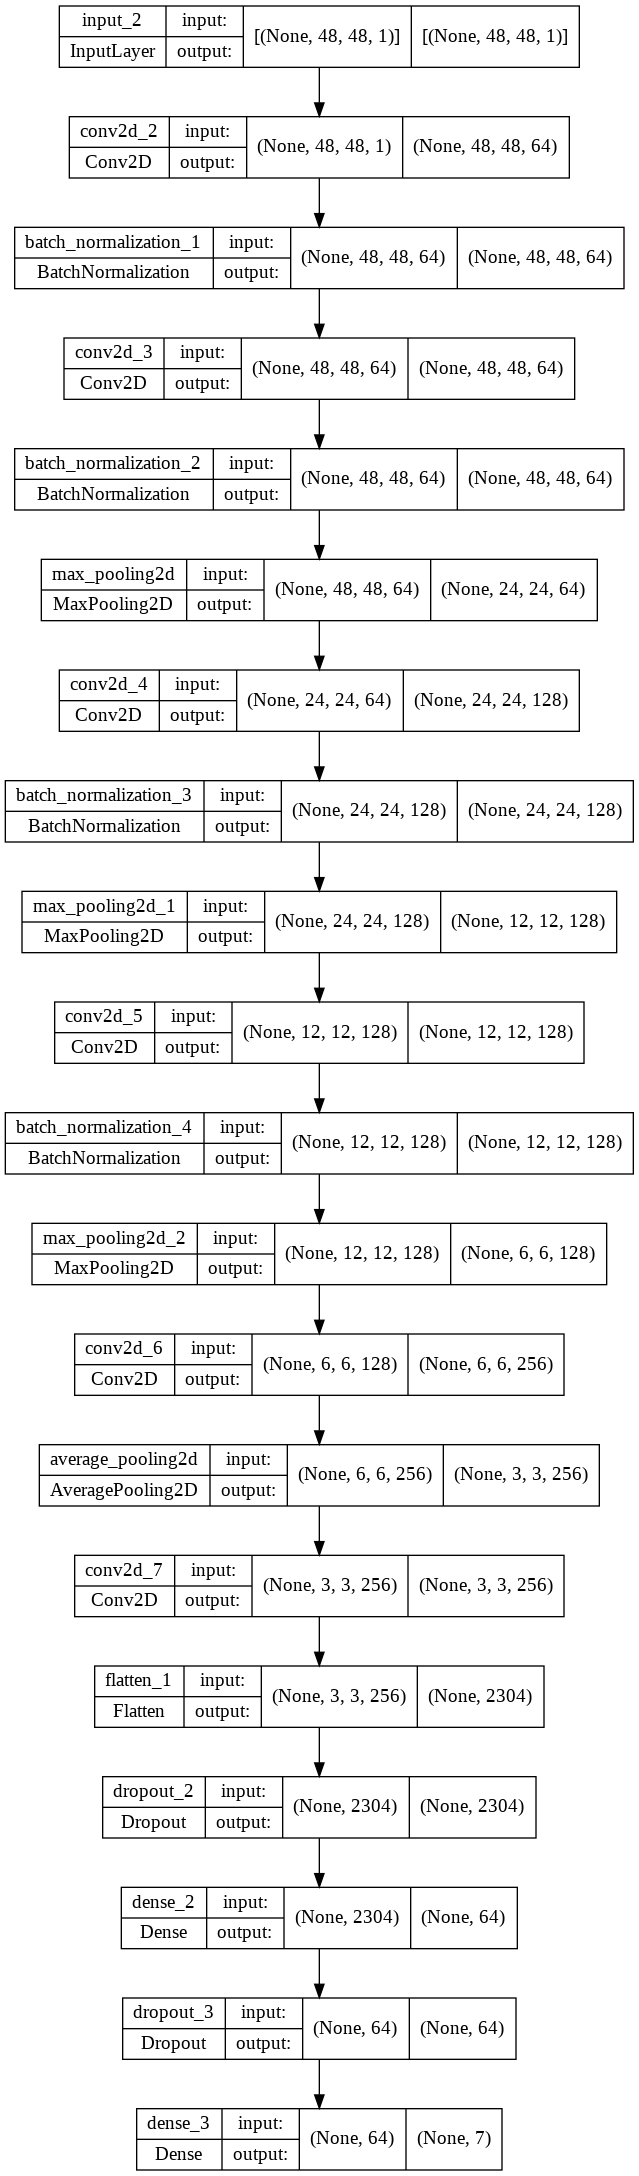

In [ ]:
keras.utils.plot_model(model, "fer_model_with_shape_info.png", show_shapes=True)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:

path= 'best_model.pt'
callback1 = ModelCheckpoint(path,monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)
callback2 = EarlyStopping(patience=10)
callback_list = [callback1, callback2]
train_history=model.fit(X_train_scaled,y_train_encoded,epochs=50,batch_size=512,callbacks=callback_list,validation_data=[X_val_scaled,y_val_encoded])

Model 2:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (48,48,1)))
emotion_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
emotion_model.add(MaxPooling2D(pool_size = (2,2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
emotion_model.add(MaxPooling2D(pool_size = (2,2)))
emotion_model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
emotion_model.add(MaxPooling2D(pool_size = (2,2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation = 'relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation = 'softmax'))


emotion_model.summary()

In [ ]:
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [ ]:
i=layers.Input(shape=X_train_scaled[0].shape)

x=layers.Conv2D(64,3,activation='relu',padding='same')(i)
x=layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(128,(3),activation='relu',padding='same')(x)
x=layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
x=layers.AveragePooling2D(3)(x)
x=layers.Flatten()(x)
x=layers.Dense(256,activation='relu')(x)
x=layers.Dense(len(set(y_train)),activation='softmax')(x)

model_new = keras.Model(inputs=i, outputs=x, name='model_n')


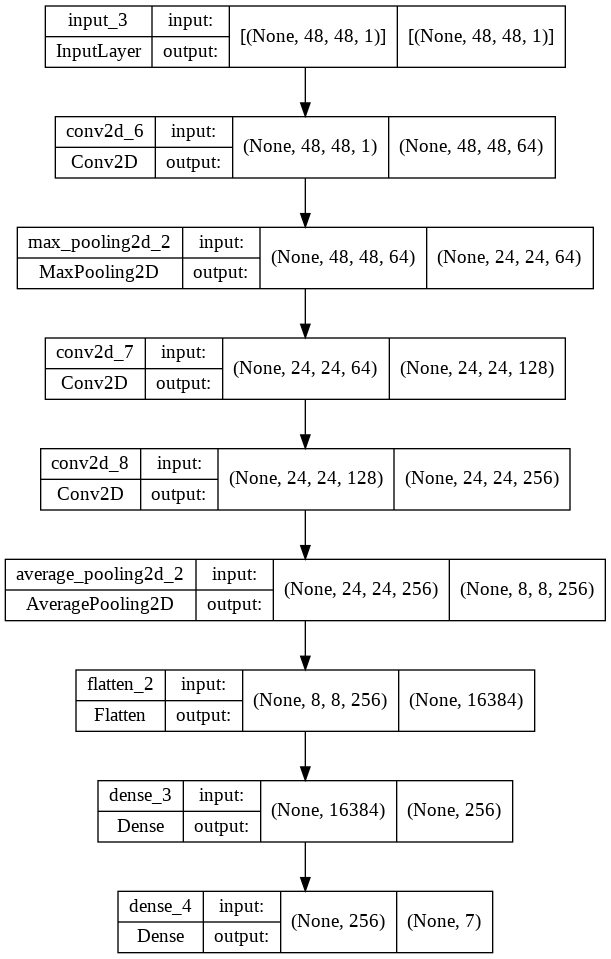

In [ ]:
keras.utils.plot_model(model_new, "fer_model_new.png", show_shapes=True)

In [ ]:
model_new.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
path= 'best_model_new_fer.pt'
callback1 = ModelCheckpoint(path,monitor='val_acc',save_best_only=True,mode='max',verbose=1)
callback2 = EarlyStopping(patience=10)
callback3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callback_list = [callback1, callback2, callback3]
train_history_new=model_new.fit(X_train_scaled,y_train_encoded,epochs=20, batch_size = 512,callbacks=callback_list,validation_data=[X_val_scaled,y_val_encoded])

Train on 28709 samples, validate on 3589 samples
Epoch 1/20
28709/28709 [==============================] - ETA: 0s - loss: 1.6380 - acc: 0.3596
Epoch 1: val_acc improved from -inf to 0.36751, saving model to best_model_new_fer.pt
28709/28709 [==============================] - 749s 26ms/sample - loss: 1.6380 - acc: 0.3596 - val_loss: 1.6284 - val_acc: 0.3675 - lr: 0.0010
Epoch 2/20
28709/28709 [==============================] - ETA: 0s - loss: 1.5291 - acc: 0.4122
Epoch 2: val_acc improved from 0.36751 to 0.40791, saving model to best_model_new_fer.pt
28709/28709 [==============================] - 742s 26ms/sample - loss: 1.5291 - acc: 0.4122 - val_loss: 1.5673 - val_acc: 0.4079 - lr: 0.0010
Epoch 3/20
28709/28709 [==============================] - ETA: 0s - loss: 1.4431 - acc: 0.4469
Epoch 3: val_acc improved from 0.40791 to 0.45026, saving model to best_model_new_fer.pt
28709/28709 [==============================] - 739s 26ms/sample - loss: 1.4431 - acc: 0.4469 - val_loss: 1.4238 - va

In [ ]:
score = model_new.evaluate(X_test_scaled, y_test_encoded)

print("Loss", score[0])
print("Accuracy", score[1])

Loss 1.834356940400471
Accuracy 0.55586517


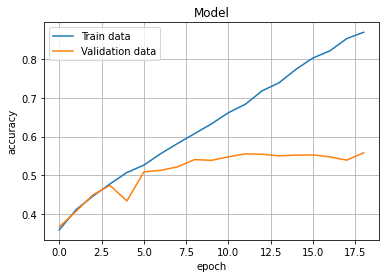

In [ ]:
plt.plot(train_history_new.history['acc'],label = 'Train data')
plt.plot(train_history_new.history['val_acc'],label = 'Validation data')

plt.legend()
plt.grid()
plt.title('Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


Pretrained network

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.applications.MobileNetV3Large import MobileNetV3Large

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(48, 48, 3))

# conv_base= tf.keras.applications.MobileNetV3Large(
#                 input_shape=(48,48,3),
#                 include_top=False,
#                 weights='imagenet',
#                 dropout_rate=0.2,)

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base.layers:
      layer.trainable = False

In [ ]:

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(df.emotion.unique()), activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 2, 2, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 256)               983296    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3,982,471
Trainable params: 985,607
Non-tr

In [ ]:
path= 'best_model.pt'
callback1 = ModelCheckpoint(path,monitor='val_acc',save_best_only=True,mode='max',verbose=1)
callback2 = EarlyStopping(patience=10)
callback_list = [callback1, callback2]
train_history_vgg16=model.fit(X_train_3c,y_train_encoded,epochs=100,batch_size=512,callbacks=callback_list,validation_data=[X_val_3c,y_val_encoded])

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 1.6899 - acc: 0.3557
Epoch 1: val_acc improved from -inf to 0.23906, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
57/57 [==============================] - 288s 5s/step - loss: 1.6899 - acc: 0.3557 - val_loss: 2.1730 - val_acc: 0.2391
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.5964 - acc: 0.3897
Epoch 2: val_acc improved from 0.23906 to 0.31485, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
57/57 [==============================] - 293s 5s/step - loss: 1.5964 - acc: 0.3897 - val_loss: 1.7070 - val_acc: 0.3149
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.5361 - acc: 0.4092
Epoch 3: val_acc did not improve from 0.31485
57/57 [==============================] - 273s 5s/step - loss: 1.5361 - acc: 0.4092 - val_loss: 1.7641 - val_acc: 0.3029
Epoch 4/20
57/57 [==============================] - ETA:

In [ ]:
score = model.evaluate(X_test_3c, y_test_encoded)

print("Loss", score[0])
print("Accuracy", score[1])


113/113 [==============================] - 89s 780ms/step - loss: 1.5121 - acc: 0.4216
Loss 1.512089490890503
Accuracy 0.4215658903121948


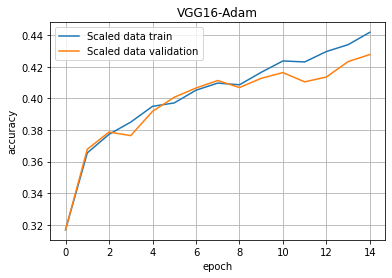

In [ ]:
plt.plot(train_history.history['acc'],label = 'Scaled data train')
plt.plot(train_history.history['val_acc'],label = 'Scaled data validation')

plt.legend()
plt.grid()
plt.title('VGG16-Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


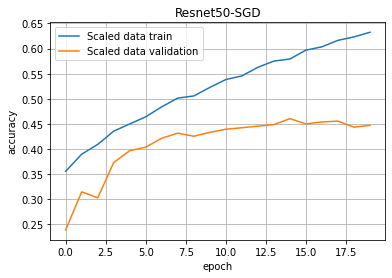

In [ ]:
plt.plot(train_history_resnet.history['acc'],label = 'Scaled data train')
plt.plot(train_history_resnet.history['val_acc'],label = 'Scaled data validation')

plt.legend()
plt.grid()
plt.title('Resnet50-SGD')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
!unzip /content/fer_model.zip

Archive:  /content/fer_model.zip
   creating: content/fer_model/
  inflating: content/fer_model/keras_metadata.pb  
   creating: content/fer_model/variables/
  inflating: content/fer_model/variables/variables.data-00000-of-00001  
  inflating: content/fer_model/variables/variables.index  
  inflating: content/fer_model/saved_model.pb  
   creating: content/fer_model/assets/


In [ ]:

model_0 = keras.models.load_model('/content/content/fer_model')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
!unzip /content/emotion_model_.zip

Archive:  /content/emotion_model_.zip
  inflating: content/emotion_modelh5.h5  


In [ ]:
model_1 = keras.models.load_model('/content/content/emotion_modelh5.h5')

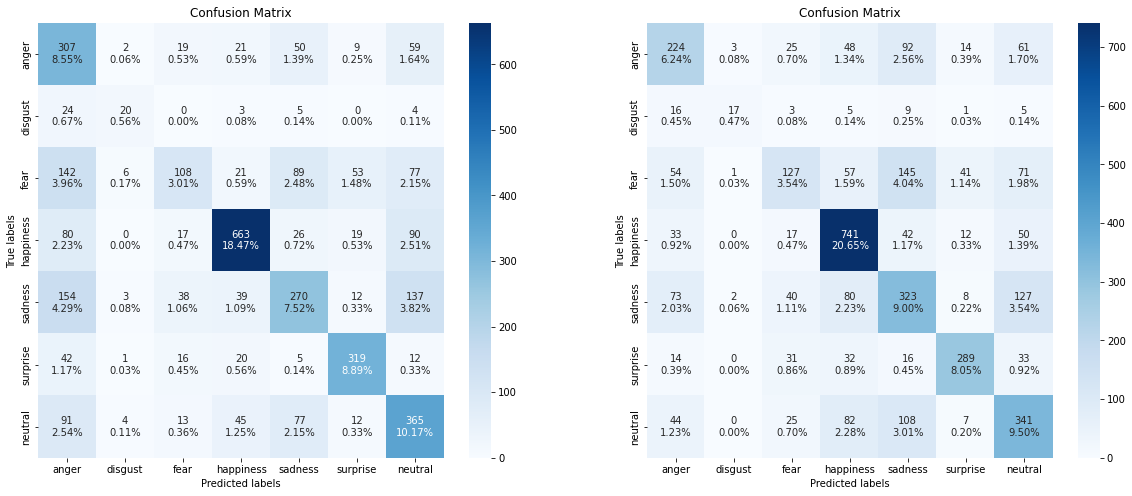

In [ ]:
print_confusion_matrix([model_0,model_1],emotion_label)

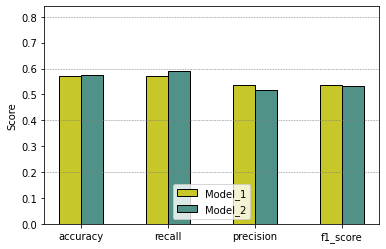

In [ ]:
barWidth = 0.25
metrics=['accuracy', 'recall', 'precision', 'f1_score']
l=[x/5 for x in range(1, 5)]

bars1 = get_metrics(model_0)
bars2 = get_metrics(model_1)

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = '#c7c729', edgecolor = 'black', capsize=7, label='Model_1')
plt.bar(r2, bars2, width = barWidth, color = '#509188', edgecolor = 'black', capsize=7, label ='Model_2')
 

plt.xticks([r + barWidth/2 for r in range(4)], metrics)
plt.ylabel('Score')
[plt.axhline(y=i,linewidth=0.5, color='gray', linestyle='--') for i in l]
plt.legend(loc='lower center')


plt.show()

## Model explainability

We will print some faces that have high probabilities (above 0.9) and run model explainability on them. 

Happy class

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


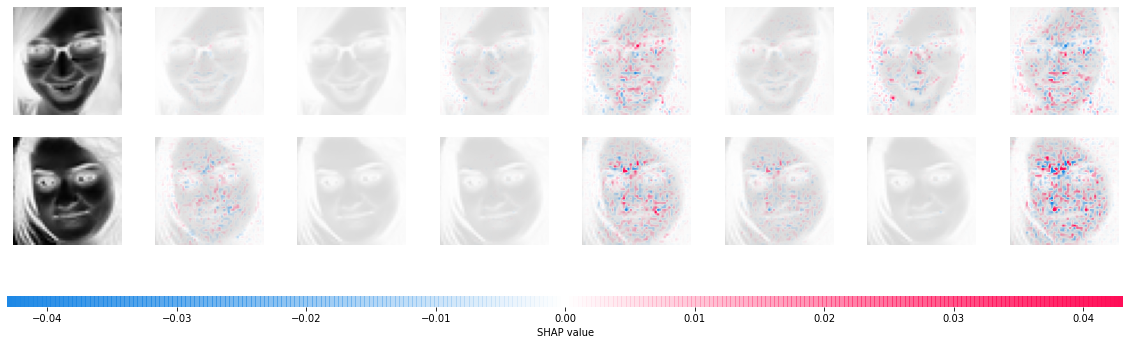

In [ ]:
# select a set of background examples to take an expectation over
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# # # explain predictions of the model on four images
e = shap.DeepExplainer(model_0, background)
# # ...or pass tensors directly
# e = shap.DeepExplainer((model_fer.layers[0].input, model_fer.layers[-1].output), background)
shap_values = e.shap_values(X_test_scaled[4:6])

# # plot the feature attributions
shap.image_plot(shap_values, -X_test_scaled[4:6])



Sad class

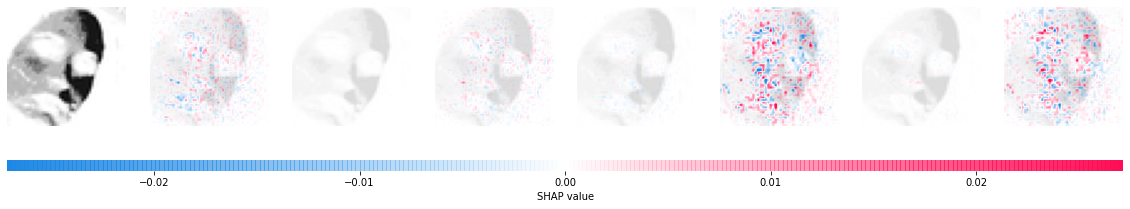

In [ ]:
# select a set of background examples to take an expectation over
# background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# # # explain predictions of the model on four images
# e = shap.DeepExplainer(model_0, background)
# # ...or pass tensors directly
# e = shap.DeepExplainer((model_fer.layers[0].input, model_fer.layers[-1].output), background)
shap_values = e.shap_values(X_test_scaled[3127:3128])

# # plot the feature attributions
shap.image_plot(shap_values, -X_test_scaled[3127:3128])



Fear class

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


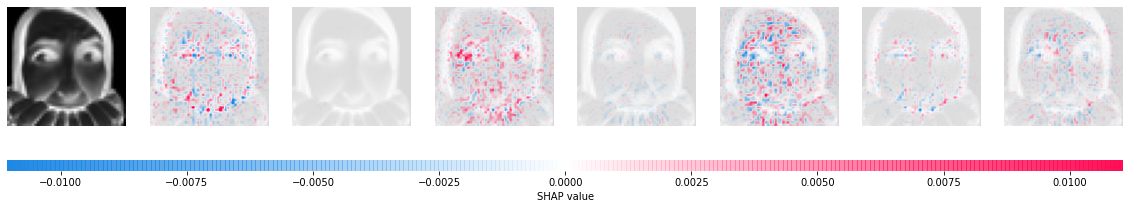

In [ ]:
# select a set of background examples to take an expectation over
# background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# # # explain predictions of the model on four images
e = shap.DeepExplainer(model_0, background)
# # ...or pass tensors directly
# e = shap.DeepExplainer((model_fer.layers[0].input, model_fer.layers[-1].output), background)
shap_values = e.shap_values(X_test_scaled[1103:1104])

# # plot the feature attributions
shap.image_plot(shap_values, -X_test_scaled[1103:1104])



# Conclusion

This is a complex and large dataset. It showed that is difficult for the models to learn it regarding the relatively low accuracy on the test data. We have tried several models, lots of them are not shown in the notebook due to its low or similar accuracy. We have tried with some our architectures and pretrained network and ours model gave better results. Regarding the model explainabilty it is clear that the model stratifies the images to a level that is not achievable by the human and thus the predictions it made are not easely explainable. But if we take some closer look of some of the more accurate predictions we can take draw some conclusion about the model thinking. Furthermore this dataset is made of images from people who are acting their emotions and we believe that the unforced emotions that we make will maybe give some other attributes that can ease or aggravate the whole prediction process.

There are a lot of things that can be done to further improve the accuracy, there are other complex architectures that can be tried or maybe use some more sophisticated transfer learning techniques. Although it should be noted that any of that will demand a lot of processor power and more importantly time.